In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow as tf
import os
from keras.preprocessing.image import img_to_array, load_img
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

devices = tf.config.experimental.list_physical_devices("GPU")
for device in devices:
    tf.config.experimental.set_memory_growth(device=device, enable=True)

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet():
    inputs = Input(shape=(256, 256, 3))
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)
    model = Model(inputs, outputs, name="U-Net")
    return model

In [44]:
segment_paths = '/Users/saptarshimallikthakur/Movies/people_segmentation/masks'
image_paths = '/Users/saptarshimallikthakur/Movies/people_segmentation/images'

segments = []
images = []



for file in tqdm(sorted(os.listdir(segment_paths))[:1000]):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        
        image_path = os.path.join(segment_paths, file)
        x = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        x = cv2.resize(x, (256, 256))
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=-1)
        segments.append(x)

for file in tqdm(sorted(os.listdir(image_paths))[:1000]):
    if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
        
        image_path = os.path.join(image_paths, file)
        x = cv2.imread(image_path)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = x/255
        x = cv2.resize(x, (256, 256))
        x = x.astype(np.float32)
        images.append(x)


segments = np.array(segments)
images = np.array(images)

100%|██████████████████████████████████████| 1000/1000 [00:03<00:00, 260.65it/s]


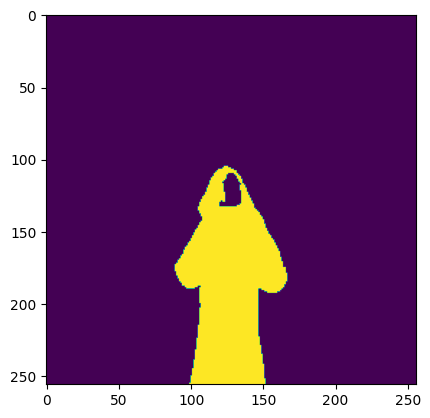

In [45]:
plt.imshow(segments[-1])

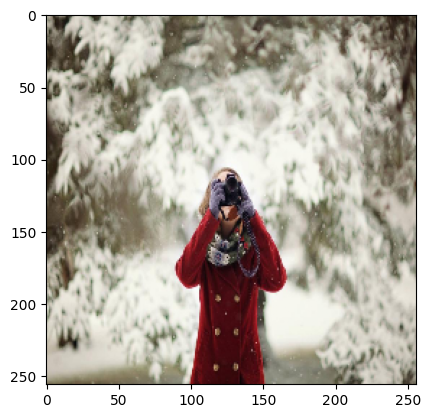

In [46]:
plt.imshow(images[-1])

In [47]:
input_shape = (256, 256, 3)
model = build_unet()
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam()
)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 64)         256       ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_18[0

 batch_normalization_26 (Ba  (None, 16, 16, 1024)         4096      ['conv2d_27[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_26 (Activation)  (None, 16, 16, 1024)         0         ['batch_normalization_26[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 16, 16, 1024)         9438208   ['activation_26[0][0]']       
                                                                                                  
 batch_normalization_27 (Ba  (None, 16, 16, 1024)         4096      ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
          

 concatenate_7 (Concatenate  (None, 256, 256, 128)        0         ['conv2d_transpose_7[0][0]',  
 )                                                                   'activation_19[0][0]']       
                                                                                                  
 conv2d_35 (Conv2D)          (None, 256, 256, 64)         73792     ['concatenate_7[0][0]']       
                                                                                                  
 batch_normalization_34 (Ba  (None, 256, 256, 64)         256       ['conv2d_35[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_34 (Activation)  (None, 256, 256, 64)         0         ['batch_normalization_34[0][0]
                                                                    ']                            
          

In [48]:
# Create a TensorFlow dataset
dataset = tf.data.Dataset.from_tensor_slices((images, segments))
dataset = dataset.batch(10)

In [49]:
model.fit(images,segments, epochs=30)

Epoch 1/30


2024-03-08 16:54:59.310652: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 153s 5s/step - loss: 0.5647
Epoch 2/30
32/32 [==============================] - 157s 5s/step - loss: 0.5056
Epoch 3/30
32/32 [==============================] - 152s 5s/step - loss: 0.4858
Epoch 4/30
32/32 [==============================] - 148s 5s/step - loss: 0.4674
Epoch 5/30
32/32 [==============================] - 148s 5s/step - loss: 0.4366
Epoch 6/30
32/32 [==============================] - 147s 5s/step - loss: 0.4134
Epoch 7/30
32/32 [==============================] - 147s 5s/step - loss: 0.4011
Epoch 8/30
32/32 [==============================] - 147s 5s/step - loss: 0.3828
Epoch 9/30
32/32 [==============================] - 147s 5s/step - loss: 0.3705
Epoch 10/30
32/32 [==============================] - 147s 5s/step - loss: 0.3615
Epoch 11/30
32/32 [==============================] - 147s 5s/step - loss: 0.3452
Epoch 12/30
32/32 [==============================] - 147s 5s/step - loss: 0.3502
Epoch 13/30
32/32 [=============================

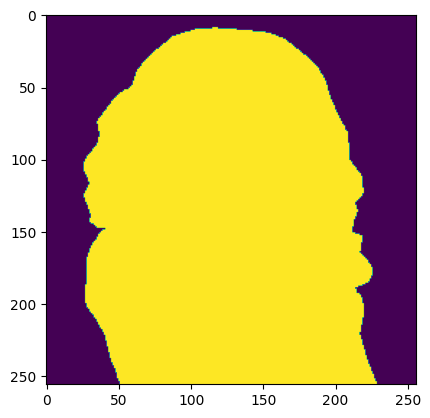

In [59]:
plt.imshow(segments[101])

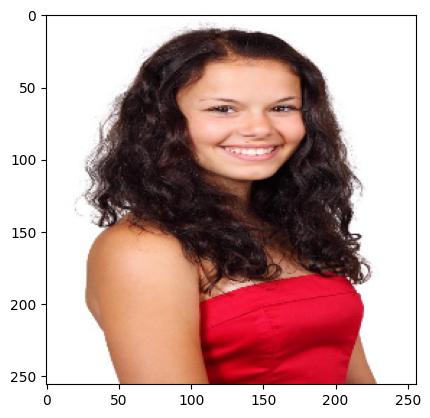

In [58]:
plt.imshow(images[101])

1/1 [==============================] - 0s 22ms/step


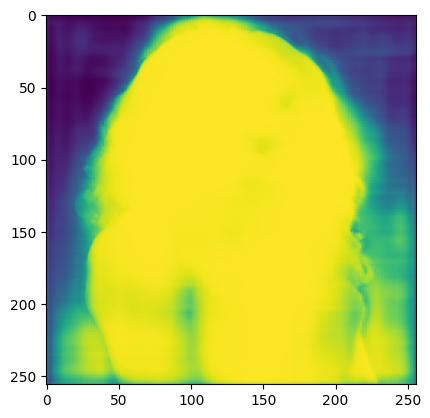

In [57]:
single_image = images[101]

# Add an extra dimension to represent the batch size
single_image_batch = np.expand_dims(single_image, axis=0)

# Now you can use single_image_batch for prediction
prediction = model.predict(single_image_batch)

plt.imshow(prediction[0])

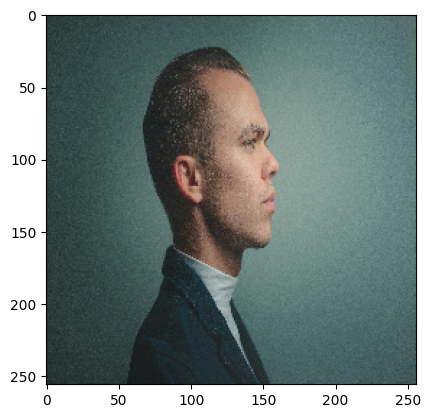

1/1 [==============================] - 0s 15ms/step


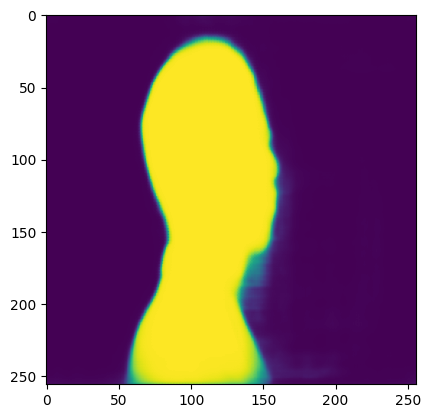

In [83]:
x = cv2.imread('example human seg.jpg')
x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
x = x/255
x = cv2.resize(x, (256, 256))
x = x.astype(np.float32)

plt.imshow(x)
plt.show()

# Add an extra dimension to represent the batch size
single_image_batch = np.expand_dims(x, axis=0)

# Now you can use single_image_batch for prediction
prediction = model.predict(single_image_batch)

plt.imshow(prediction[0])

In [60]:
from tensorflow.keras.models import load_model, save_model

# Assuming you have a trained UNet model named 'unet_model'
# Train your model before saving

# Save the entire model
save_model(model, 'model_unet_human.h5')

/var/folders/9n/8cclcvkn0mzdkqdn7vn8k4440000gn/T/ipykernel_1025/1400639939.py:7: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'model_unet_human.h5')


In [64]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
import tensorflow as tf


video_path = "Elon_Musk.mp4"

""" Load the model """
model_u = tf.keras.models.load_model("model_unet_human.h5")

In [77]:
cap = cv2.VideoCapture(video_path)
idx = 0
frames= []
while True:
        ret, frame = cap.read()
        if ret == False:
            cap.release()
            out.release()
            break

        H, W, _ = frame.shape
        ori_frame = frame
        frame = cv2.resize(frame, (256, 256))         # 256,256,3
        frame = np.expand_dims(frame, axis=0)  # 1,256,256,3
        frame = frame / 255.0

        mask = model.predict(frame)[0]
        mask = mask > 0.5
        mask = mask.astype(np.float32)
        mask = cv2.resize(mask, (W, H))
        mask = np.expand_dims(mask, axis=-1)
#         plt.imshow(mask)
#         plt.show()

        combine_frame = ori_frame * mask
        combine_frame = combine_frame.astype(np.uint8)
        frames.append(combine_frame)
        idx +=1

#         cv2.imwrite(f"video/{idx}.png", combine_frame)

#         out.write(combine_frame)

1/1 [==============================] - 0s 11ms/step


KeyboardInterrupt: 

In [78]:
# Set the output video file name
output_video = "output_video.mp4"

# Get the dimensions of the first image array
height, width, _ = frames[0].shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for AVI format
fps = 24  # Set the desired frame rate
video = cv2.VideoWriter(output_video, fourcc, fps, (width, height))

# Loop through the image array list and write each frame to the video
for image_array in frames:
    video.write(image_array)

# Release the VideoWriter and destroy any open CV windows
video.release()
cv2.destroyAllWindows()